In [ ]:
from torch import nn


class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
import h5py
import numpy as np
from torch.utils.data import Dataset


class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            print(f['lr'][idx].shape)
            return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])


class EvalDataset(Dataset):
    def __init__(self, h5_file):
        super(EvalDataset, self).__init__()
        self.h5_file = h5_file

    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            return np.expand_dims(f['lr'][str(idx)][:, :] / 255., 0), np.expand_dims(f['hr'][str(idx)][:, :] / 255., 0)

    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [ ]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class ImageDataset(Dataset):
    def __init__(self, root, hr_shape, lr_factor):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // lr_factor, hr_height // lr_factor), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )

        self.files = sorted(glob.glob(root + "/*.png"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)
  

In [ ]:
import torch
import numpy as np


def convert_rgb_to_y(img):
    if type(img) == np.ndarray:
        return 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        return 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
    else:
        raise Exception('Unknown Type', type(img))


def convert_rgb_to_ycbcr(img):
    if type(img) == np.ndarray:
        y = 16. + (64.738 * img[:, :, 0] + 129.057 * img[:, :, 1] + 25.064 * img[:, :, 2]) / 256.
        cb = 128. + (-37.945 * img[:, :, 0] - 74.494 * img[:, :, 1] + 112.439 * img[:, :, 2]) / 256.
        cr = 128. + (112.439 * img[:, :, 0] - 94.154 * img[:, :, 1] - 18.285 * img[:, :, 2]) / 256.
        return np.array([y, cb, cr]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        y = 16. + (64.738 * img[0, :, :] + 129.057 * img[1, :, :] + 25.064 * img[2, :, :]) / 256.
        cb = 128. + (-37.945 * img[0, :, :] - 74.494 * img[1, :, :] + 112.439 * img[2, :, :]) / 256.
        cr = 128. + (112.439 * img[0, :, :] - 94.154 * img[1, :, :] - 18.285 * img[2, :, :]) / 256.
        return torch.cat([y, cb, cr], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def convert_ycbcr_to_rgb(img):
    if type(img) == np.ndarray:
        r = 298.082 * img[:, :, 0] / 256. + 408.583 * img[:, :, 2] / 256. - 222.921
        g = 298.082 * img[:, :, 0] / 256. - 100.291 * img[:, :, 1] / 256. - 208.120 * img[:, :, 2] / 256. + 135.576
        b = 298.082 * img[:, :, 0] / 256. + 516.412 * img[:, :, 1] / 256. - 276.836
        return np.array([r, g, b]).transpose([1, 2, 0])
    elif type(img) == torch.Tensor:
        if len(img.shape) == 4:
            img = img.squeeze(0)
        r = 298.082 * img[0, :, :] / 256. + 408.583 * img[2, :, :] / 256. - 222.921
        g = 298.082 * img[0, :, :] / 256. - 100.291 * img[1, :, :] / 256. - 208.120 * img[2, :, :] / 256. + 135.576
        b = 298.082 * img[0, :, :] / 256. + 516.412 * img[1, :, :] / 256. - 276.836
        return torch.cat([r, g, b], 0).permute(1, 2, 0)
    else:
        raise Exception('Unknown Type', type(img))


def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
epoch: 0/49: 100%|██████████| 21904/21904 [04:37<00:00, 78.99it/s, loss=0.001584]


eval psnr: 35.26


epoch: 1/49: 100%|██████████| 21904/21904 [04:34<00:00, 79.73it/s, loss=0.000718]


eval psnr: 35.49


epoch: 2/49: 100%|██████████| 21904/21904 [04:43<00:00, 77.19it/s, loss=0.000688]


eval psnr: 35.57


epoch: 3/49: 100%|██████████| 21904/21904 [04:49<00:00, 75.57it/s, loss=0.000712]


eval psnr: 35.67


epoch: 4/49: 100%|██████████| 21904/21904 [04:52<00:00, 74.81it/s, loss=0.000652]


eval psnr: 35.40


epoch: 5/49: 100%|██████████| 21904/21904 [04:48<00:00, 75.99it/s, loss=0.000648]


eval psnr: 35.84


epoch: 6/49: 100%|██████████| 21904/21904 [04:49<00:00, 75.58it/s, loss=0.000641]


eval psnr: 35.94


epoch: 7/49: 100%|██████████| 21904/21904 [04:51<00:00, 75.19it/s, loss=0.000621]


eval psnr: 36.03


epoch: 8/49: 100%|██████████| 21904/21904 [05:03<00:00, 72.14it/s, loss=0.000614]


eval psnr: 36.03


epoch: 9/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.11it/s, loss=0.000608]


eval psnr: 35.97


epoch: 10/49: 100%|██████████| 21904/21904 [04:56<00:00, 73.77it/s, loss=0.000606]


eval psnr: 36.07


epoch: 11/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.19it/s, loss=0.000597]


eval psnr: 36.13


epoch: 12/49: 100%|██████████| 21904/21904 [04:53<00:00, 74.71it/s, loss=0.000598]


eval psnr: 36.14


epoch: 13/49: 100%|██████████| 21904/21904 [04:50<00:00, 75.38it/s, loss=0.000588]


eval psnr: 36.22


epoch: 14/49: 100%|██████████| 21904/21904 [04:50<00:00, 75.32it/s, loss=0.000587]


eval psnr: 36.17


epoch: 15/49: 100%|██████████| 21904/21904 [04:37<00:00, 78.91it/s, loss=0.000583]


eval psnr: 36.27


epoch: 16/49: 100%|██████████| 21904/21904 [04:49<00:00, 75.72it/s, loss=0.000583]


eval psnr: 36.21


epoch: 17/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.38it/s, loss=0.000578]


eval psnr: 36.28


epoch: 18/49: 100%|██████████| 21904/21904 [04:49<00:00, 75.74it/s, loss=0.000575]


eval psnr: 36.32


epoch: 19/49: 100%|██████████| 21904/21904 [04:50<00:00, 75.48it/s, loss=0.000576]


eval psnr: 36.32


epoch: 20/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.20it/s, loss=0.000572]


eval psnr: 34.35


epoch: 21/49: 100%|██████████| 21904/21904 [04:58<00:00, 73.38it/s, loss=0.000568]


eval psnr: 36.20


epoch: 22/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.01it/s, loss=0.000568]


eval psnr: 36.23


epoch: 23/49: 100%|██████████| 21904/21904 [04:52<00:00, 74.76it/s, loss=0.000567]


eval psnr: 35.87


epoch: 24/49: 100%|██████████| 21904/21904 [04:49<00:00, 75.65it/s, loss=0.000565]


eval psnr: 36.21


epoch: 25/49: 100%|██████████| 21904/21904 [04:48<00:00, 75.83it/s, loss=0.000567]


eval psnr: 36.37


epoch: 26/49: 100%|██████████| 21904/21904 [04:52<00:00, 74.81it/s, loss=0.000561]


eval psnr: 36.22


epoch: 27/49: 100%|██████████| 21904/21904 [05:01<00:00, 72.77it/s, loss=0.000562]


eval psnr: 36.33


epoch: 28/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.30it/s, loss=0.000559]


eval psnr: 36.34


epoch: 29/49: 100%|██████████| 21904/21904 [04:58<00:00, 73.46it/s, loss=0.000557]


eval psnr: 36.21


epoch: 30/49: 100%|██████████| 21904/21904 [04:41<00:00, 77.73it/s, loss=0.000556]


eval psnr: 36.16


epoch: 31/49: 100%|██████████| 21904/21904 [04:51<00:00, 75.14it/s, loss=0.000556]


eval psnr: 36.39


epoch: 32/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.39it/s, loss=0.000552]


eval psnr: 36.43


epoch: 33/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.24it/s, loss=0.000554]


eval psnr: 36.42


epoch: 34/49: 100%|██████████| 21904/21904 [04:52<00:00, 74.77it/s, loss=0.000552]


eval psnr: 36.38


epoch: 35/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.10it/s, loss=0.000551]


eval psnr: 36.36


epoch: 36/49: 100%|██████████| 21904/21904 [04:53<00:00, 74.52it/s, loss=0.000552]


eval psnr: 36.41


epoch: 37/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.29it/s, loss=0.000549]


eval psnr: 36.44


epoch: 38/49: 100%|██████████| 21904/21904 [04:56<00:00, 73.93it/s, loss=0.000547]


eval psnr: 36.38


epoch: 39/49: 100%|██████████| 21904/21904 [04:51<00:00, 75.25it/s, loss=0.000548]


eval psnr: 36.46


epoch: 40/49: 100%|██████████| 21904/21904 [04:58<00:00, 73.47it/s, loss=0.000548]


eval psnr: 36.33


epoch: 41/49: 100%|██████████| 21904/21904 [04:57<00:00, 73.64it/s, loss=0.000546]


eval psnr: 36.17


epoch: 42/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.50it/s, loss=0.000545]


eval psnr: 36.42


epoch: 43/49: 100%|██████████| 21904/21904 [04:54<00:00, 74.48it/s, loss=0.000544]


eval psnr: 36.44


epoch: 44/49: 100%|██████████| 21904/21904 [05:01<00:00, 72.54it/s, loss=0.000545]


eval psnr: 36.28


epoch: 45/49: 100%|██████████| 21904/21904 [05:08<00:00, 71.00it/s, loss=0.000543]


eval psnr: 35.29


epoch: 46/49: 100%|██████████| 21904/21904 [04:55<00:00, 74.19it/s, loss=0.000543]


eval psnr: 36.37


epoch: 47/49: 100%|██████████| 21904/21904 [05:01<00:00, 72.64it/s, loss=0.000542]


eval psnr: 36.44


epoch: 48/49: 100%|██████████| 21904/21904 [04:56<00:00, 73.82it/s, loss=0.000540]


eval psnr: 36.45


epoch: 49/49: 100%|██████████| 21904/21904 [05:01<00:00, 72.70it/s, loss=0.000541]


eval psnr: 36.43
best epoch: 39, psnr: 36.46


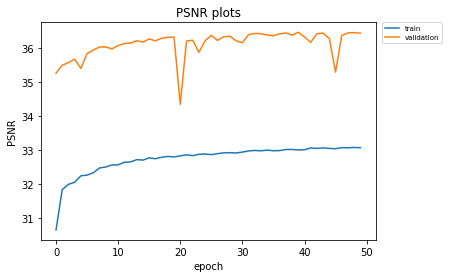

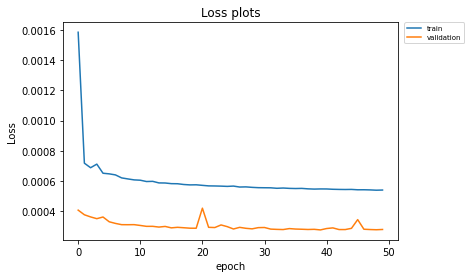

In [ ]:
import argparse
import os
import copy

import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm


if __name__ == '__main__':

    train_file = "/content/drive/MyDrive/ML Project/91-image_x2.h5"
    eval_file = "/content/drive/MyDrive/ML Project/Set5_x2.h5"
    scale = 2
    outputs_dir = "/output"
    lr = 0.001
    batch_size = 16
    num_epochs = 50
    num_workers = 8
    seed = 123

    outputs_dir = os.path.join(outputs_dir, 'x{}'.format(scale))

    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir)


    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    torch.manual_seed(seed)

    model = SRCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam([
        {'params': model.conv1.parameters()},
        {'params': model.conv2.parameters()},
        {'params': model.conv3.parameters(), 'lr': lr * 0.1}
    ], lr=lr)

    train_dataset = TrainDataset(train_file)
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
    eval_dataset = EvalDataset(eval_file)
    eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=1)

    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 0.0

    epoch_train_psnrs = []
    epoch_val_psnrs = []

    epoch_train_losses = []
    epoch_val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses_training = AverageMeter()
        epoch_psnr_training = AverageMeter()

        with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
            t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))

            for data in train_dataloader:
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.to(device)

                preds = model(inputs)

                loss = criterion(preds, labels)

                epoch_losses_training.update(loss.item(), len(inputs))
                epoch_psnr_training.update(calc_psnr(preds, labels), len(inputs))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                t.set_postfix(loss='{:.6f}'.format(epoch_losses_training.avg))
                
                t.update(len(inputs))

        epoch_train_losses.append(epoch_losses_training.avg)
        epoch_train_psnrs.append(epoch_psnr_training.avg)

        torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch)))

        model.eval()
        epoch_psnr_val = AverageMeter()
        epoch_losses_val = AverageMeter()
        for data in eval_dataloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                preds = model(inputs).clamp(0.0, 1.0)
            
            loss = criterion(preds, labels)
            epoch_psnr_val.update(calc_psnr(preds, labels), len(inputs))
            epoch_losses_val.update(loss.item(), len(inputs))

        print('eval psnr: {:.2f}'.format(epoch_psnr_val.avg))
        epoch_val_psnrs.append(epoch_psnr_val.avg)
        epoch_val_losses.append(epoch_losses_val.avg)

        if epoch_psnr_val.avg > best_psnr:
            best_epoch = epoch
            best_psnr = epoch_psnr_val.avg
            best_weights = copy.deepcopy(model.state_dict())

    print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
    torch.save(best_weights, os.path.join(outputs_dir, 'best.pth'))

    from matplotlib import pyplot as plt
    epoch_train_psnrs_values = [x.detach().numpy() for x in epoch_train_psnrs]
    epoch_val_psnrs_values = [x.detach().numpy() for x in epoch_val_psnrs]
    plt.plot(epoch_train_psnrs_values)
    plt.plot(epoch_val_psnrs_values)
    plt.title("PSNR plots")
    plt.ylabel("PSNR")
    plt.xlabel("epoch")
    plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

    plt.savefig("/content/drive/MyDrive/ML Project/SRCNN_Model_PSNR.png", bbox_inches="tight", dpi=600)
    plt.show()

    plt.plot(epoch_train_losses)
    plt.plot(epoch_val_losses)
    plt.title("Loss plots")
    plt.ylabel("Loss")
    plt.xlabel("epoch")
    plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

    plt.savefig("/content/drive/MyDrive/ML Project/SRCNN_Model_MSE_loss.png", bbox_inches="tight", dpi=600)
    plt.show()

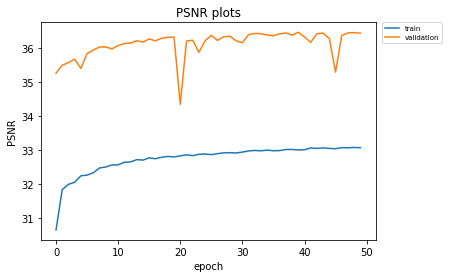

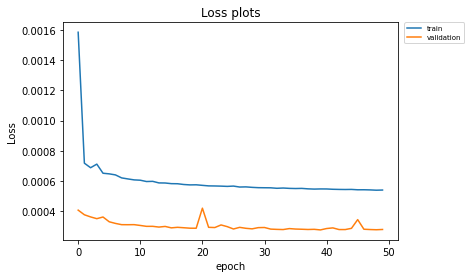

In [ ]:
from matplotlib import pyplot as plt
epoch_train_psnrs_values = [x.detach().numpy() for x in epoch_train_psnrs]
epoch_val_psnrs_values = [x.detach().numpy() for x in epoch_val_psnrs]
plt.plot(epoch_train_psnrs_values)
plt.plot(epoch_val_psnrs_values)
plt.title("PSNR plots")
plt.ylabel("PSNR")
plt.xlabel("epoch")
plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

plt.savefig("/content/drive/MyDrive/ML Project/SRCNN_Model_PSNR.png", bbox_inches="tight", dpi=600)
plt.show()


plt.plot(epoch_train_losses)
plt.plot(epoch_val_losses)
plt.title("Loss plots")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(
        ["train", "validation"],
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize="x-small",
    )

plt.savefig("/content/drive/MyDrive/ML Project/SRCNN_Model_MSE_loss.png", bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
with h5py.File("/content/drive/MyDrive/ML Project/91-image_x2.h5", 'r') as f:
  print(f['hr'])
  # return np.expand_dims(f['lr'][idx] / 255., 0), np.expand_dims(f['hr'][idx] / 255., 0)
  print(np.expand_dims(f['lr'][0] / 255., 0).shape)


with h5py.File("/content/drive/MyDrive/ML Project/Set5_x2.h5", 'r') as f:
  print(f['lr']['4'])
  print(len(f['lr']))

<HDF5 dataset "hr": shape (21910, 33, 33), type "<f4">
(1, 33, 33)
<HDF5 dataset "4": shape (344, 228), type "<f4">
5
